# SAMueL-2 hospital improvement demo

This notebook runs core analysis from the SAMueL analysis on use of thrombolysis in stroke. It is made up of machine learning components (which must be run first) and whole pathway modelling.

## Machine learning

The machine learning module runs two models, both of which use XGBoost as the predictor model, and SHAP for the explainability model:

### Thrombolysis choice

For each patient we predict whether each team would give that patient thrombolysis or not. This model is based on those patients arriving at hopsital within 4 hours of known stroke onset time. As part of the model, how each team affects the odds of a patient receiving thrombolysis is estimated. This is held in the 'SHAP' value for stroke team, and is expressed as the log-odds that is added to the model prediction on use of thrombolysis due to the stroke team attended. Those 25 stroke teams with the highest SHAP values are labelled as *benchmark* stroke teams. As part of pathway modelling we examine how thrombolysis use would be affected if the decision to give thrombolysis or not was made according to a majority vote of predicted *benchmark* stroke teams decisions.

Features used to predict use of thrombolysis are:

* Stroke team
* Stroke type (ischaemic/haemorrhagic)
* Prior disability (modified Rankin Scale)
* Stroke severity (total NIHSS score*)
* Onset known type (precise or estimated)
* Onset-during sleep (Y/N)
* Onset-to-arrival time
* Arrival-to-scan time
* Use of anticoagulants for atrial fibrillation (Y/N)
* Age

*For NIHSS stroke severity score see https://en.wikipedia.org/wiki/National_Institutes_of_Health_Stroke_Scale. 

### Patient outcome

For each ischaemic stroke patient, we predict the outcome on discharge from inpatient care based on key patient characteristics and use/time of thrombolysis. Outcome prediction is a probability distribution of modified Rankin Scale (mRS):

| Score |Description                                                                                                             |
|-------|------------------------------------------------------------------------------------------------------------------------|
| 0     | No symptoms.                                                                                                           |
| 1     | No significant disability. Able to carry out all usual activities, despite some symptoms.                              |
| 2     | Slight disability. Able to look after own affairs without assistance, but unable to carry out all previous activities. |
| 3     | Moderate disability. Requires some help, but able to walk unassisted.                                                  |
| 4     | Moderately severe disability. Unable to attend to own bodily needs without assistance, and unable to walk unassisted.  |
| 5     | Severe disability. Requires constant nursing care and attention, bedridden, incontinent.                               |
| 6     | Dead.                                                                                                                  |

In addition to mRS, we may calculate utility-weighted mRS (UW-mRS). UW-mRS incorporates both treatment effect and patient perceived quality of life as a single outcome measure for stroke trials. UW-mRS scores are based on a pooled analysis of 20,000+ patients, from Wang et al (2020). The Utilities for each mRS level are shown below.  

| mRS Score | 0    | 1    | 2    | 3    | 4    | 5     | 6    |
|-----------|------|------|------|------|------|-------|------|
| Utility   | 0.97 | 0.88 | 0.74 | 0.55 | 0.20 | -0.19 | 0.00 |

Features used to predict outcome after stroke are:

* Stroke team
* Prior disability (modified Rankin Scale)
* Stroke severity (total NIHSS score)
* Onset known type (precise or estimated)
* Diagnosis of atrial fibrillation (Y/N)
* Onset-to-thrombolysis time (or use a dummy value of 99999 if thrombolysis not received)
* Age

Outcome predictions also allow us to make *counterfactual* predictions of what the outcome is likely to be with and without thrombolysis, and so we may estimate the potential benefit (or harm) of thrombolysis for any patient.

*Wang X, Moullaali TJ, Li Q, Berge E, Robinson TG, Lindley R, et al. Utility-Weighted Modified Rankin Scale Scores for the Assessment of Stroke Outcome. Stroke. 2020 Aug 1;51(8):2411-7.*

## Pathway simulation

The pathway mimics the flow of individual patients through each hospital's thrombolysis pathway - sampling from distributions based on each hospital's historic performance. Stroke outcome (the number of outcomes with modified Rankin Scale of 0-1) is predicted from a mathematical model based on clinical trial results, based on use and time of thrombolysis.

Three changes (alone or combined) are made to the pathway to examine the effect of possible improvements.

1. SPEED: Time from arrival to thrombolysis (for those selected for thrombolysis) is set at 30 minutes (15 minutes arrival to scan, and 15 minutes scan to thrombolysis), without variation, for 95% of arrivals (iwe assume 5% of patients with stroke are atypical and are not scanned in time for thrombolysis).

2. ONSET: The proportion of patients with a determined stroke onset time varies significantly between stroke teams. We find the upper quartile performance in determining stroke teams, and model the effect of reaching that performance if currently lower than that.

3. BENCHMARK DECISIONS: For each stroke team we use the machine learning model to predict what the thrombolysis rate would be, for patients scanned in time for thrombolysis, if decisions were made according to the majority vote of 25 *benchmark stroke teams* (those with the greatest propensity to use thrombolysis; see above).

## Outputs

The following outputs are generated and saved in the `output` folder:

* *sim_results_all.csv* : Results for pathway simulation for each stroke team and scenario.

* *sim_results_summary.csv* : Summary for pathway simulation scenarios aggregated for all stroke teams combined.

* *sim_results_summary.jpg* : Graphical summary for pathway simulation scenarios aggregated for all stroke teams combined.

* *sim_results_team_team_x.jpg* : Graphical results for pathway simulation scenarios at a single.

* *thrombolysis_choice_hospital_shap.csv* : Average SHAP values for use of thombolysis for each stroke team. This is the effect of stroke team attended on the log-odds of receiving thrombolysis.

* *thrombolysis_choice_results.csv* : Detailed results for prediction of thrombolysis use, and outcome, for each patient.

* *thrombolysis_choice_shap.csv* : For each patient the prediction of use of thrombolysis is explained by the SHAP values for each patient. 

* *thrombolysis_outcome_predictions_by_team.csv* : Average machine learning results by stroke team.

* *thrombolysis_rates.csv* : For each stroke teams, this records for patients arriving within 4 hours of known stroke onset (1) observed thrombolysis use, 2) predicted use of thrombolysis if benchmark decisions made, predicted thrombolysis use if decision made on best predicted outcome from machine learnign model (with a conservative view that no person on anticoagulant therapy for atrial fibrillation should be considered for thrombolysis).

## Import modules

In [1]:
from utils.pathway import Pathway
from utils.thrombolysis_choice_outcome import ThrombolysisChoiceOutcome
from utils.calculate_sim_paramaters import CalculateSimParameters

# Remove warnings for demo
import warnings; warnings.filterwarnings("ignore")

## Choose to use artificial or real data

This repository only contains artificial data, but the analysis may be performed on real SSNAP data stored in an alternative location.

In [2]:
use_artificial_data = True

if use_artificial_data:
    data_path = './artificial_data'
else:
    data_path = './real_data'

## Run machine learning models

Machine learning models in this notebook are trained on the entire data set. The accuracy reported here should not be used for formal accuracy testing (see separate notebooks on *k-fold* testing). Both thrombolysis use predictions and outcome predictions are coded in the same module.

In [3]:
# Run machine learning models and save results
choice_outcome_model = ThrombolysisChoiceOutcome(data_path)
choice_outcome_model.run()


Accuracy scores are for guidance only; all data is used to fit model
ROC AUC: 0.940
Actual thrombolysis: 0.273
Predicted thrombolysis: 0.257

Accuracy score is for guidance only; all data is used to fit model
Outcome multiclass ROC AUC 0.874


## Run pathway simulation

To run the pathway simulation, the required distributions are first calculated based on historic SSNAP data.

In [4]:
# Summarise data for sim model
sim_param_calc = CalculateSimParameters(data_path)

Scenarios are then run with alternative pathway parameters.

In [5]:
# Run pathway model and save results
pathway = Pathway(data_path, trials=5)
pathway.run()

### Plot summary results across all stroke teams

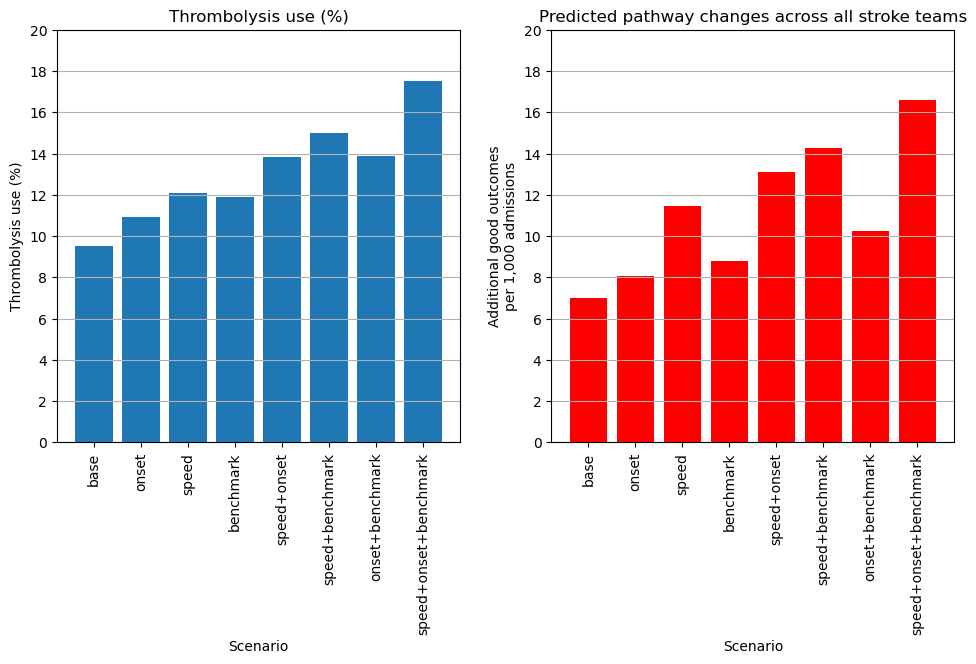

In [6]:
pathway.plot_summary_results(show=True)

### Plot pathway results for as single stroke team

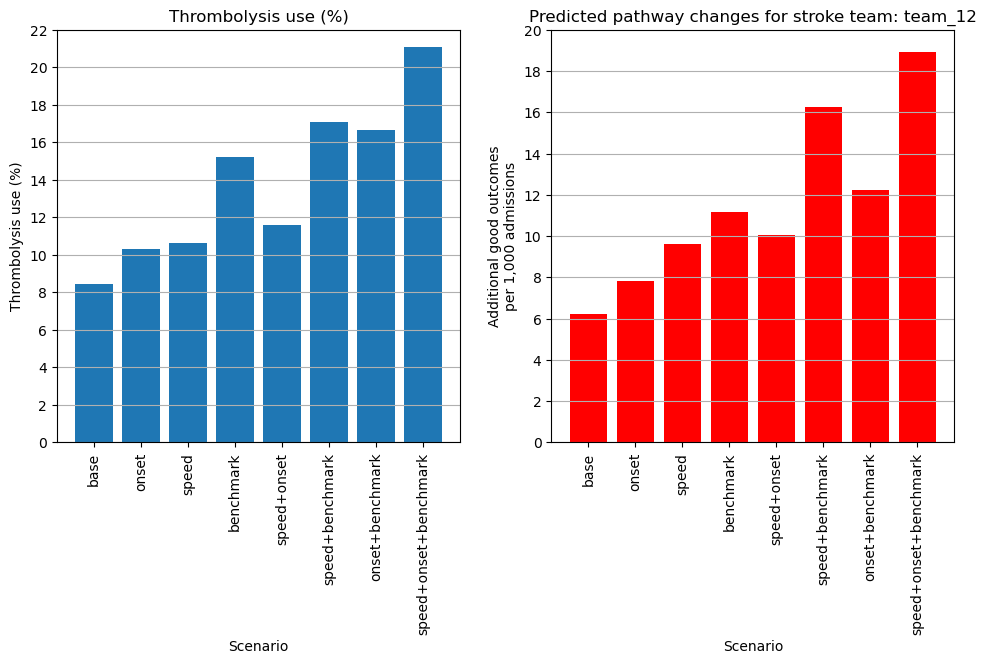

In [7]:
team = 'team_12'
pathway.plot_team_results(team, show=True)